In [1]:
import geopandas as gpd
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from GeoConformalizedExplainer import GeoConformalizedExplainer

C:\Users\Xiayin\miniconda3\envs\UncertaintyGeoXAI\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data = pd.read_csv('../data/china_sites_2018_05_PM2.5_all.csv')

In [3]:
data.head()

,id,name,city,lon,lat,date,PM2.5,row_index,col_index,proj_x,...,t2m,sp,tp,blh,e,r,u10,v10,aod_sat,ndvi
0,1001A,万寿西宫,北京,116.366,39.8673,20180531,60.548387,2201.0,6867.0,1.650848e+06,...,293.967224,100044.187500,0.000634,164.847870,-0.000010,44.939587,0.764578,1.060548,0.660040,3932
1,1002A,定陵,北京,116.170,40.2865,20180531,57.224138,2134.0,6835.0,1.625004e+06,...,291.590820,96484.054688,0.000450,101.149689,-0.000010,51.034016,0.007471,-0.032906,0.568065,7575
2,1003A,东四,北京,116.434,39.9522,20180531,67.258065,2188.0,6877.0,1.653777e+06,...,294.037201,100061.195312,0.000598,163.240631,-0.000009,44.052452,0.581442,1.025983,0.683423,3769
3,1004A,天坛,北京,116.434,39.8745,20180531,57.080645,2200.0,6877.0,1.655828e+06,...,294.102112,100167.195312,0.000655,175.418289,-0.000011,44.226921,0.670114,1.145302,0.653063,4337
4,1005A,农展馆,北京,116.473,39.9716,20180531,57.935484,2185.0,6884.0,1.656225e+06,...,294.140289,100108.039062,0.000601,169.096985,-0.000009,43.352154,0.494377,1.053341,0.653476,3757


In [4]:
pm25 = data['PM2.5']

In [5]:
features = data[['dem', 'sp', 'tp', 'blh', 'r', 'aod_sat', 'ndvi', 'lon', 'lat']]

In [6]:
loc = data[['lon', 'lat']]

In [7]:
X_train, X_temp, y_train, y_temp, loc_train, loc_temp = train_test_split(features, pm25, loc, train_size=0.8, random_state=42)

In [8]:
X_calib, X_test, y_calib, y_test, loc_calib, loc_test = train_test_split(X_temp, y_temp, loc_temp, train_size=0.5, random_state=42)

In [9]:
model = xgb.XGBRegressor(n_estimators=400, max_depth=3, min_child_weight=0.8, colsample_bytree=0.8)

In [10]:
model.fit(X_train.values, y_train.values)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=0.8, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=400, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [11]:
model.score(X_test, y_test)

0.7357700953125248

In [12]:
feature_names = X_train.columns

In [13]:
explainer = GeoConformalizedExplainer(prediction_f=model.predict,
                                      x_train=X_train,
                                      x_calib=X_calib,
                                      coord_calib=loc_calib.values,
                                      miscoverage_level=0.1,
                                      band_width=5,
                                      feature_names=feature_names)

In [14]:
results = explainer.uncertainty_aware_explain(x_test=X_test, coord_test=loc_test.values)

Training SHAP


100%|██████████| 1132/1132 [06:00<00:00,  3.14it/s]


Calibrating SHAP


100%|██████████| 141/141 [00:45<00:00,  3.12it/s]


Testing SHAP


100%|██████████| 142/142 [00:50<00:00,  2.80it/s]


Explaining Variables


In [15]:
results.accuracy_summary()

,coverage_probability,R2,RMSE,SHAP_Var,Pred_SHAP_Var
dem,0.894366,0.866052,1.163113,10.099682,11.922356
sp,0.873239,0.685644,0.941263,2.818379,1.665811
tp,0.894366,0.656989,0.895551,2.338153,1.713410
blh,0.901408,0.331440,1.328198,2.638670,1.806334
r,0.901408,0.924360,0.961617,12.225115,13.312034
aod_sat,0.901408,0.937375,1.310469,27.422553,26.600634
ndvi,0.894366,0.166136,1.110850,1.479843,1.018567
lon,0.936620,0.859551,1.063212,8.048603,7.422913
lat,0.894366,0.884586,1.192329,12.317777,11.559241


In [16]:
results.accuracy_summary().to_csv('./ChinaPM25_accuracy_summary_1.csv')

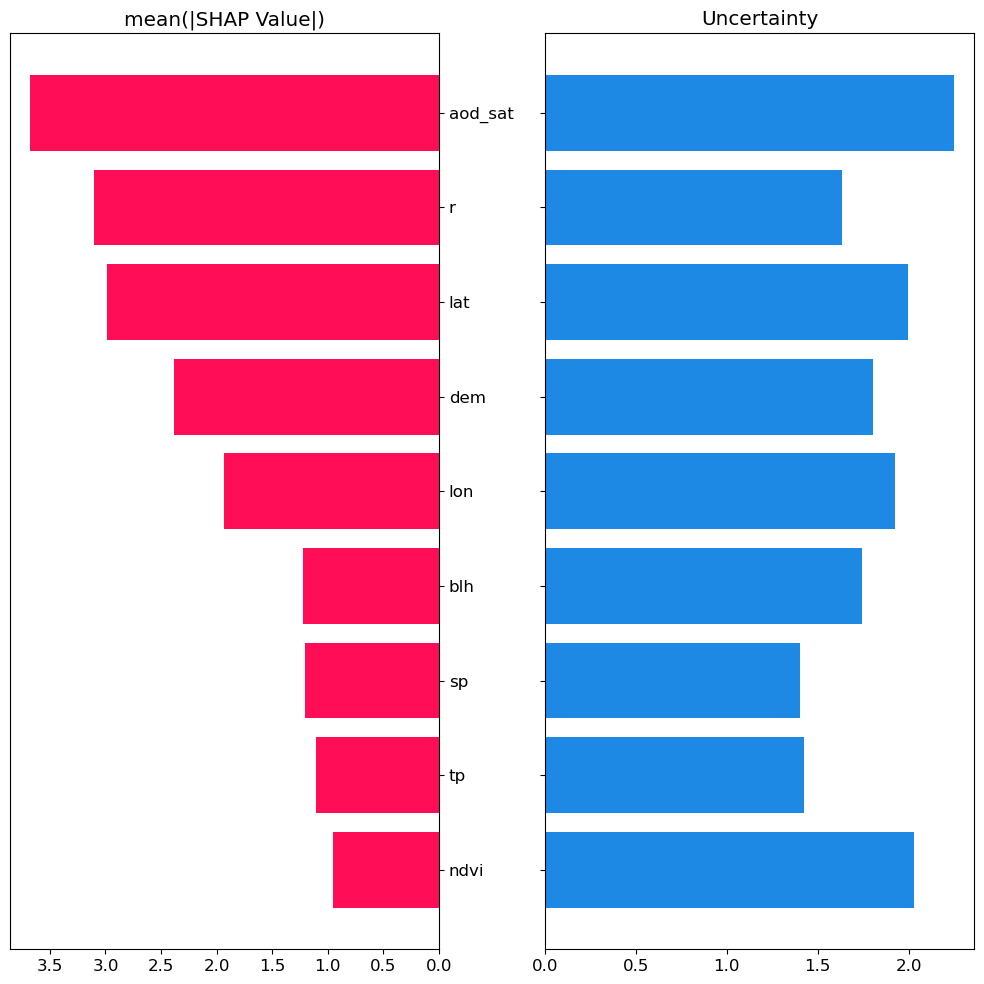

In [17]:
results.plot_absolute_shap_value_with_uncertainty(filename='./ChinaPM25_absolute_shap_value_with_uncertainty_1.pdf')

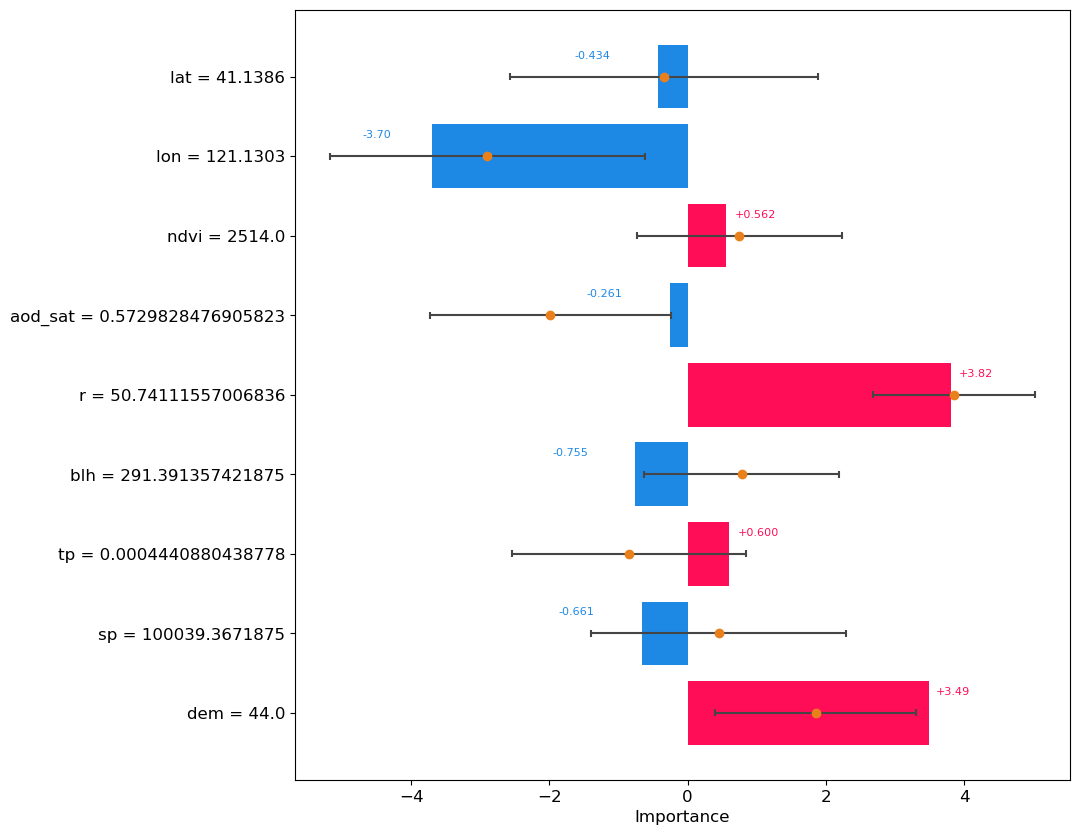

In [30]:
 results.plot_shap_values_with_uncertainty(15, filename='./ChinaPM25_shap_values_with_uncertainty_1.pdf')

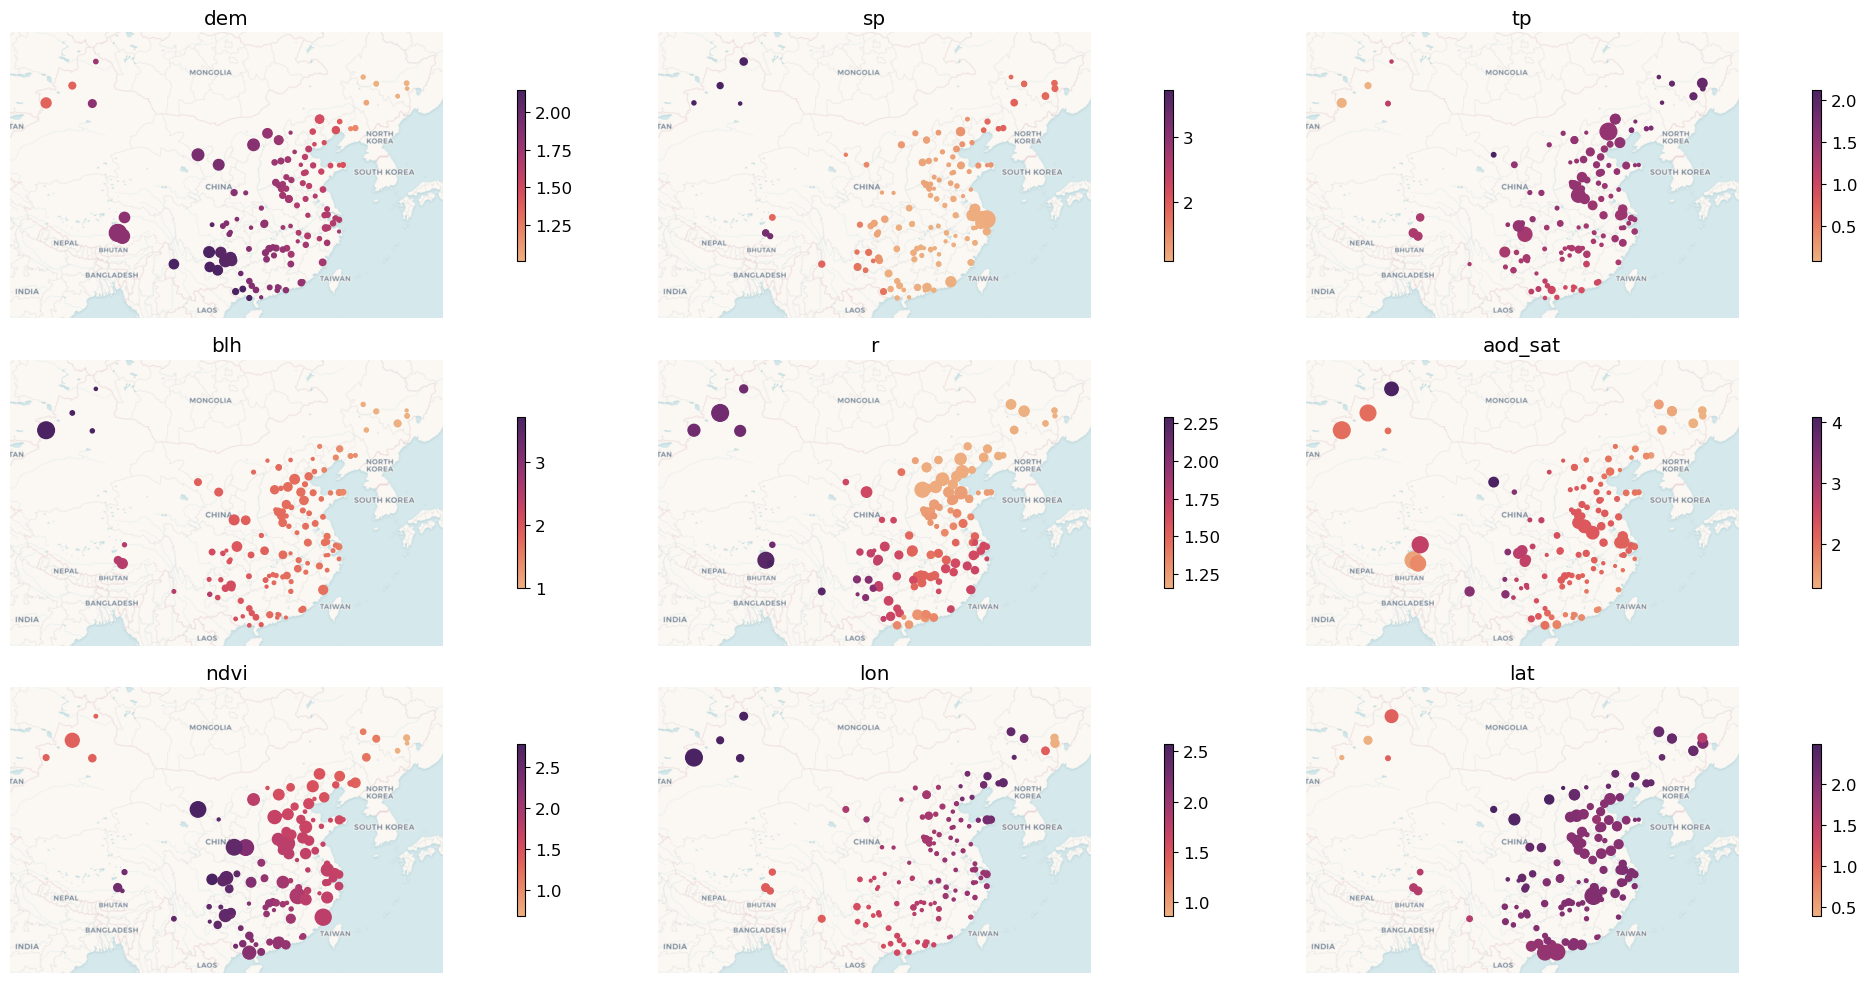

In [28]:
results.plot_geo_uncertainty(max_cols=3, figsize=(28, 10), shrink=0.6, filename='./ChinaPM25_geo_uncertainty_1.pdf')

100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00

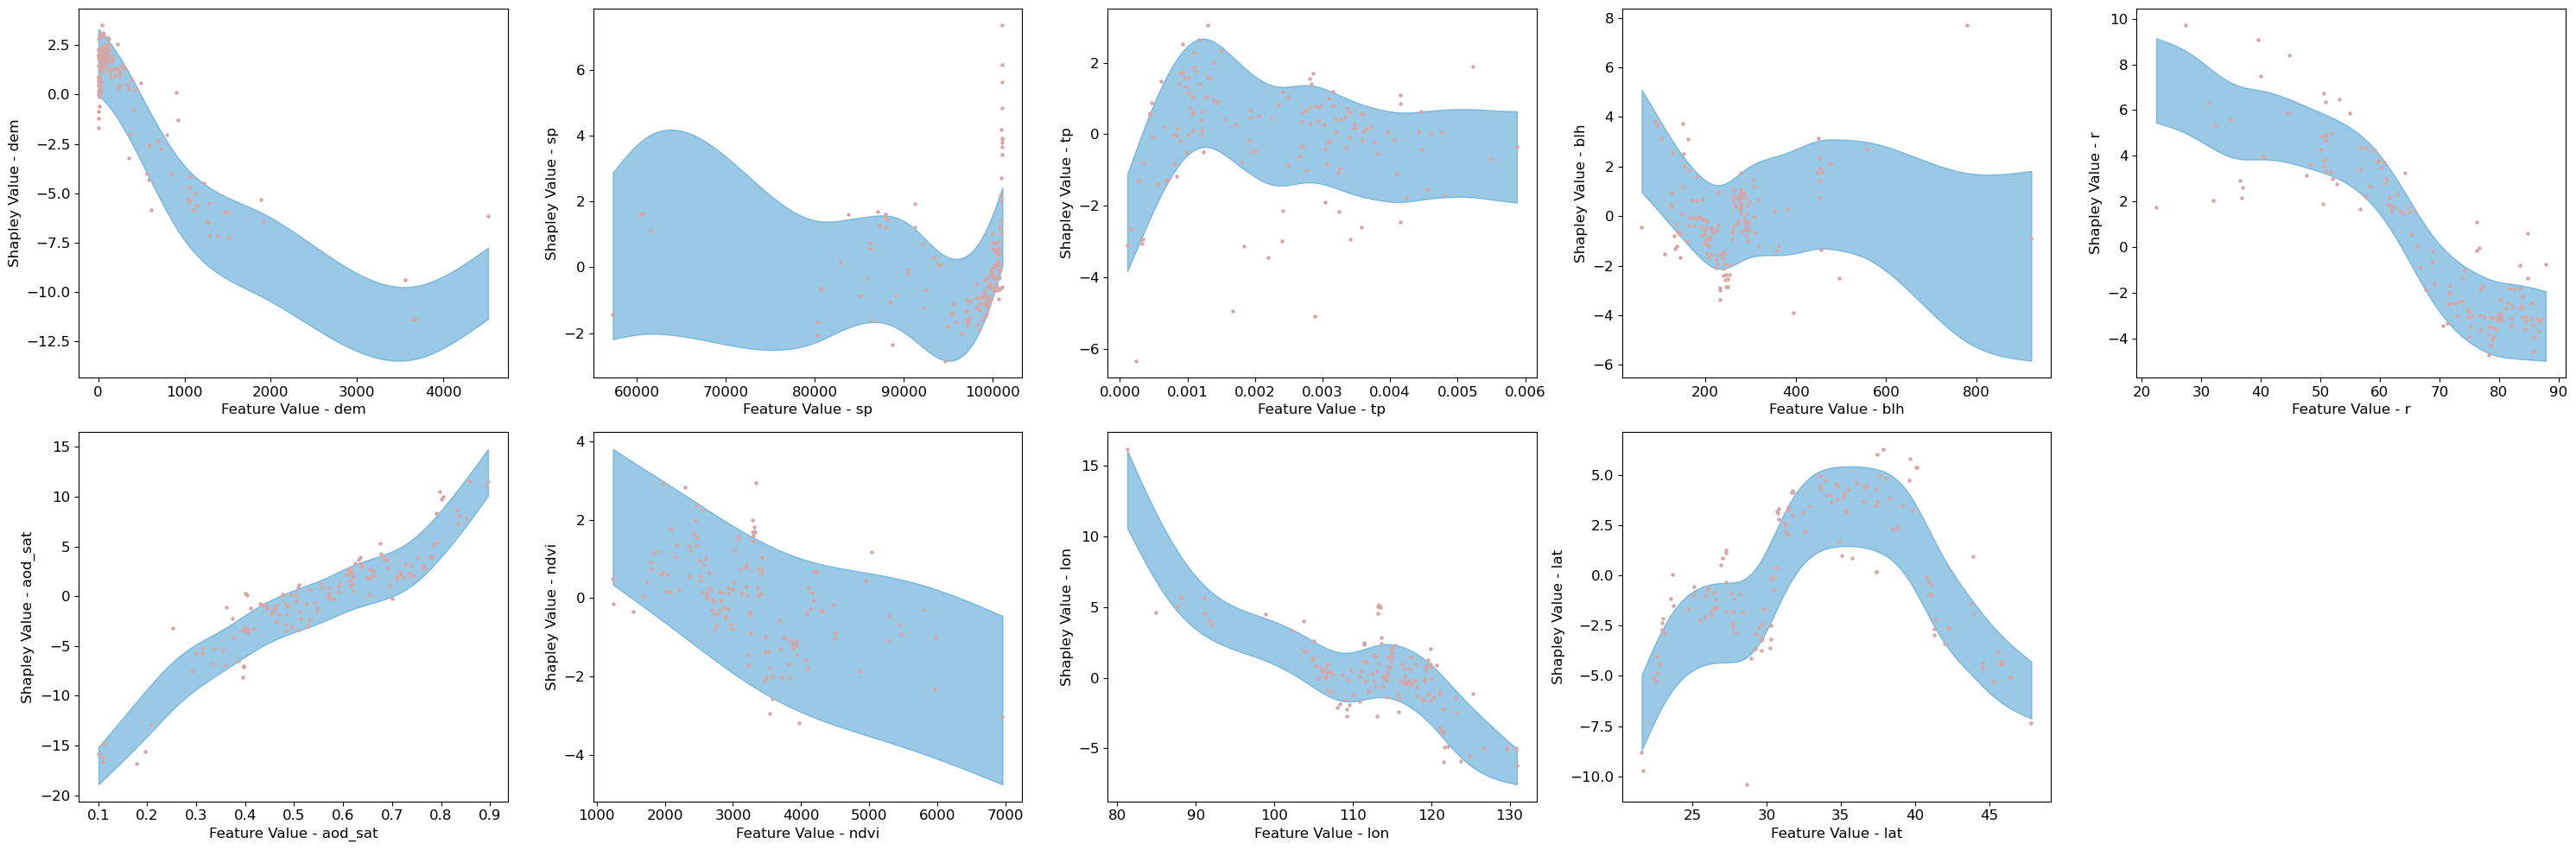

In [20]:
results.plot_partial_dependence_with_fitted_bounds(filename='./ChinaPM25_partial_dependence_with_fitted_bounds_1.pdf')

In [21]:
import matplotlib.pyplot as plt
import geoplot as gplt
import geoplot.crs as gcrs
import contextily as cx

In [22]:
data_geo = gpd.GeoDataFrame(data, crs="EPSG:4326", geometry=gpd.points_from_xy(x=data.lon, y=data.lat))

In [23]:
data_geo

,id,name,city,lon,lat,date,PM2.5,row_index,col_index,proj_x,...,sp,tp,blh,e,r,u10,v10,aod_sat,ndvi,geometry
0,1001A,万寿西宫,北京,116.3660,39.8673,20180531,60.548387,2201.0,6867.0,1.650848e+06,...,100044.187500,0.000634,164.847870,-0.000010,44.939587,0.764578,1.060548,0.660040,3932,POINT (116.36600 39.86730)
1,1002A,定陵,北京,116.1700,40.2865,20180531,57.224138,2134.0,6835.0,1.625004e+06,...,96484.054688,0.000450,101.149689,-0.000010,51.034016,0.007471,-0.032906,0.568065,7575,POINT (116.17000 40.28650)
2,1003A,东四,北京,116.4340,39.9522,20180531,67.258065,2188.0,6877.0,1.653777e+06,...,100061.195312,0.000598,163.240631,-0.000009,44.052452,0.581442,1.025983,0.683423,3769,POINT (116.43400 39.95220)
3,1004A,天坛,北京,116.4340,39.8745,20180531,57.080645,2200.0,6877.0,1.655828e+06,...,100167.195312,0.000655,175.418289,-0.000011,44.226921,0.670114,1.145302,0.653063,4337,POINT (116.43400 39.87450)
4,1005A,农展馆,北京,116.4730,39.9716,20180531,57.935484,2185.0,6884.0,1.656225e+06,...,100108.039062,0.000601,169.096985,-0.000009,43.352154,0.494377,1.053341,0.653476,3757,POINT (116.47300 39.97160)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1410,3141A,信访局,安阳,114.3922,36.0878,20180531,37.274194,2806.0,6551.0,1.590509e+06,...,99902.937500,0.000313,257.324127,-0.000015,56.635887,0.024895,0.496677,0.684397,3140,POINT (114.39220 36.08780)
1411,3147A,龙亭公园,开封,114.3442,34.8097,20180531,35.833333,3011.0,6543.0,1.616838e+06,...,100060.773438,0.000834,257.716949,-0.000017,61.475670,-0.638843,1.309099,0.748552,3250,POINT (114.34420 34.80970)
1412,3148A,区人社局,眉山,103.8286,30.0561,20180531,33.709677,3771.0,4861.0,7.928102e+05,...,95982.710938,0.001630,202.957428,-0.000022,65.617638,0.390761,-0.182472,0.705915,3503,POINT (103.82860 30.05610)
1413,3149A,笔架山北路,黄石,115.0158,30.1594,20180531,33.193548,3755.0,6651.0,1.784937e+06,...,100341.062500,0.003359,192.892776,-0.000027,76.779602,-1.045102,0.231252,0.652169,4354,POINT (115.01580 30.15940)


In [24]:
china_border = gpd.read_file('../data/china_border.gpkg')

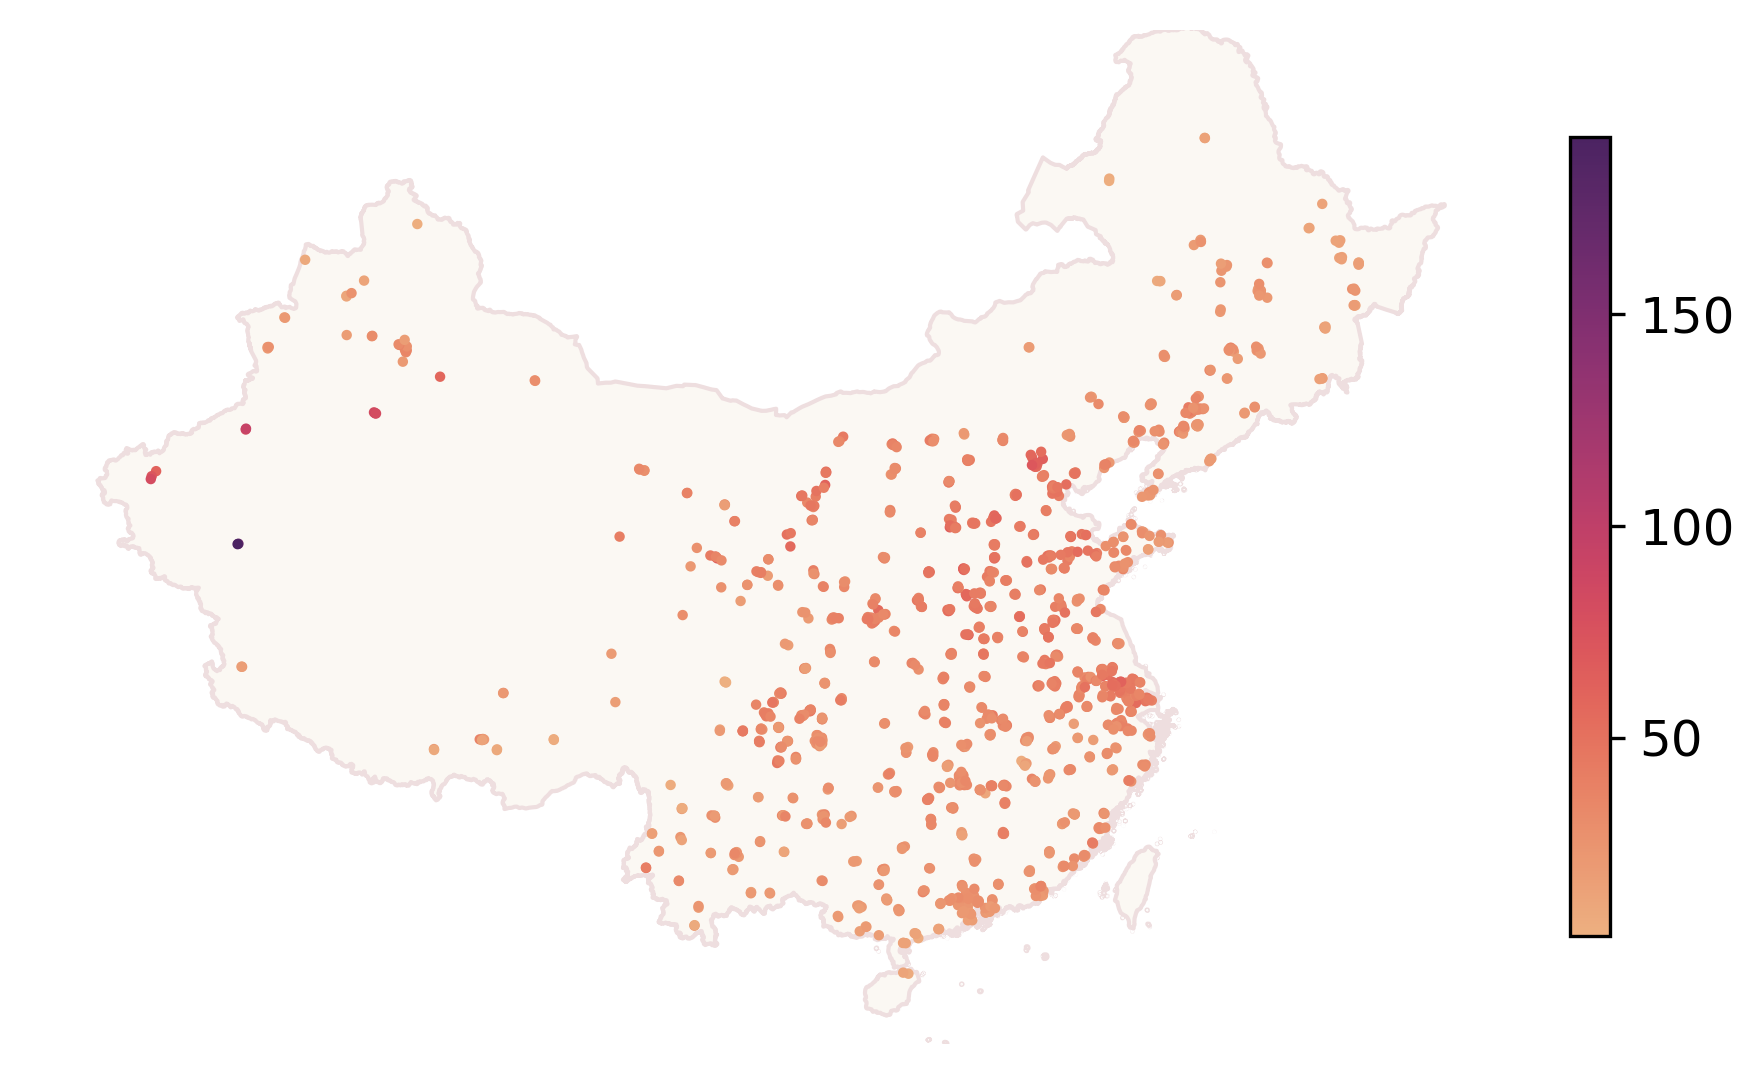

In [25]:
utm = gcrs.WebMercator()

fig, ax = plt.subplots(dpi=300, subplot_kw={'projection': utm})

gplt.polyplot(china_border, zorder=-1,
    linewidth=1,
    projection=utm,
    edgecolor='#eededf',
    facecolor='#fbf8f3', ax=ax)
gplt.pointplot(data_geo, hue='PM2.5', cmap='flare', legend=True, legend_kwargs={'shrink': 0.6}, s=1.5, ax=ax)

plt.tight_layout()
plt.savefig('./china_pm25_distribution.pdf')
plt.show()

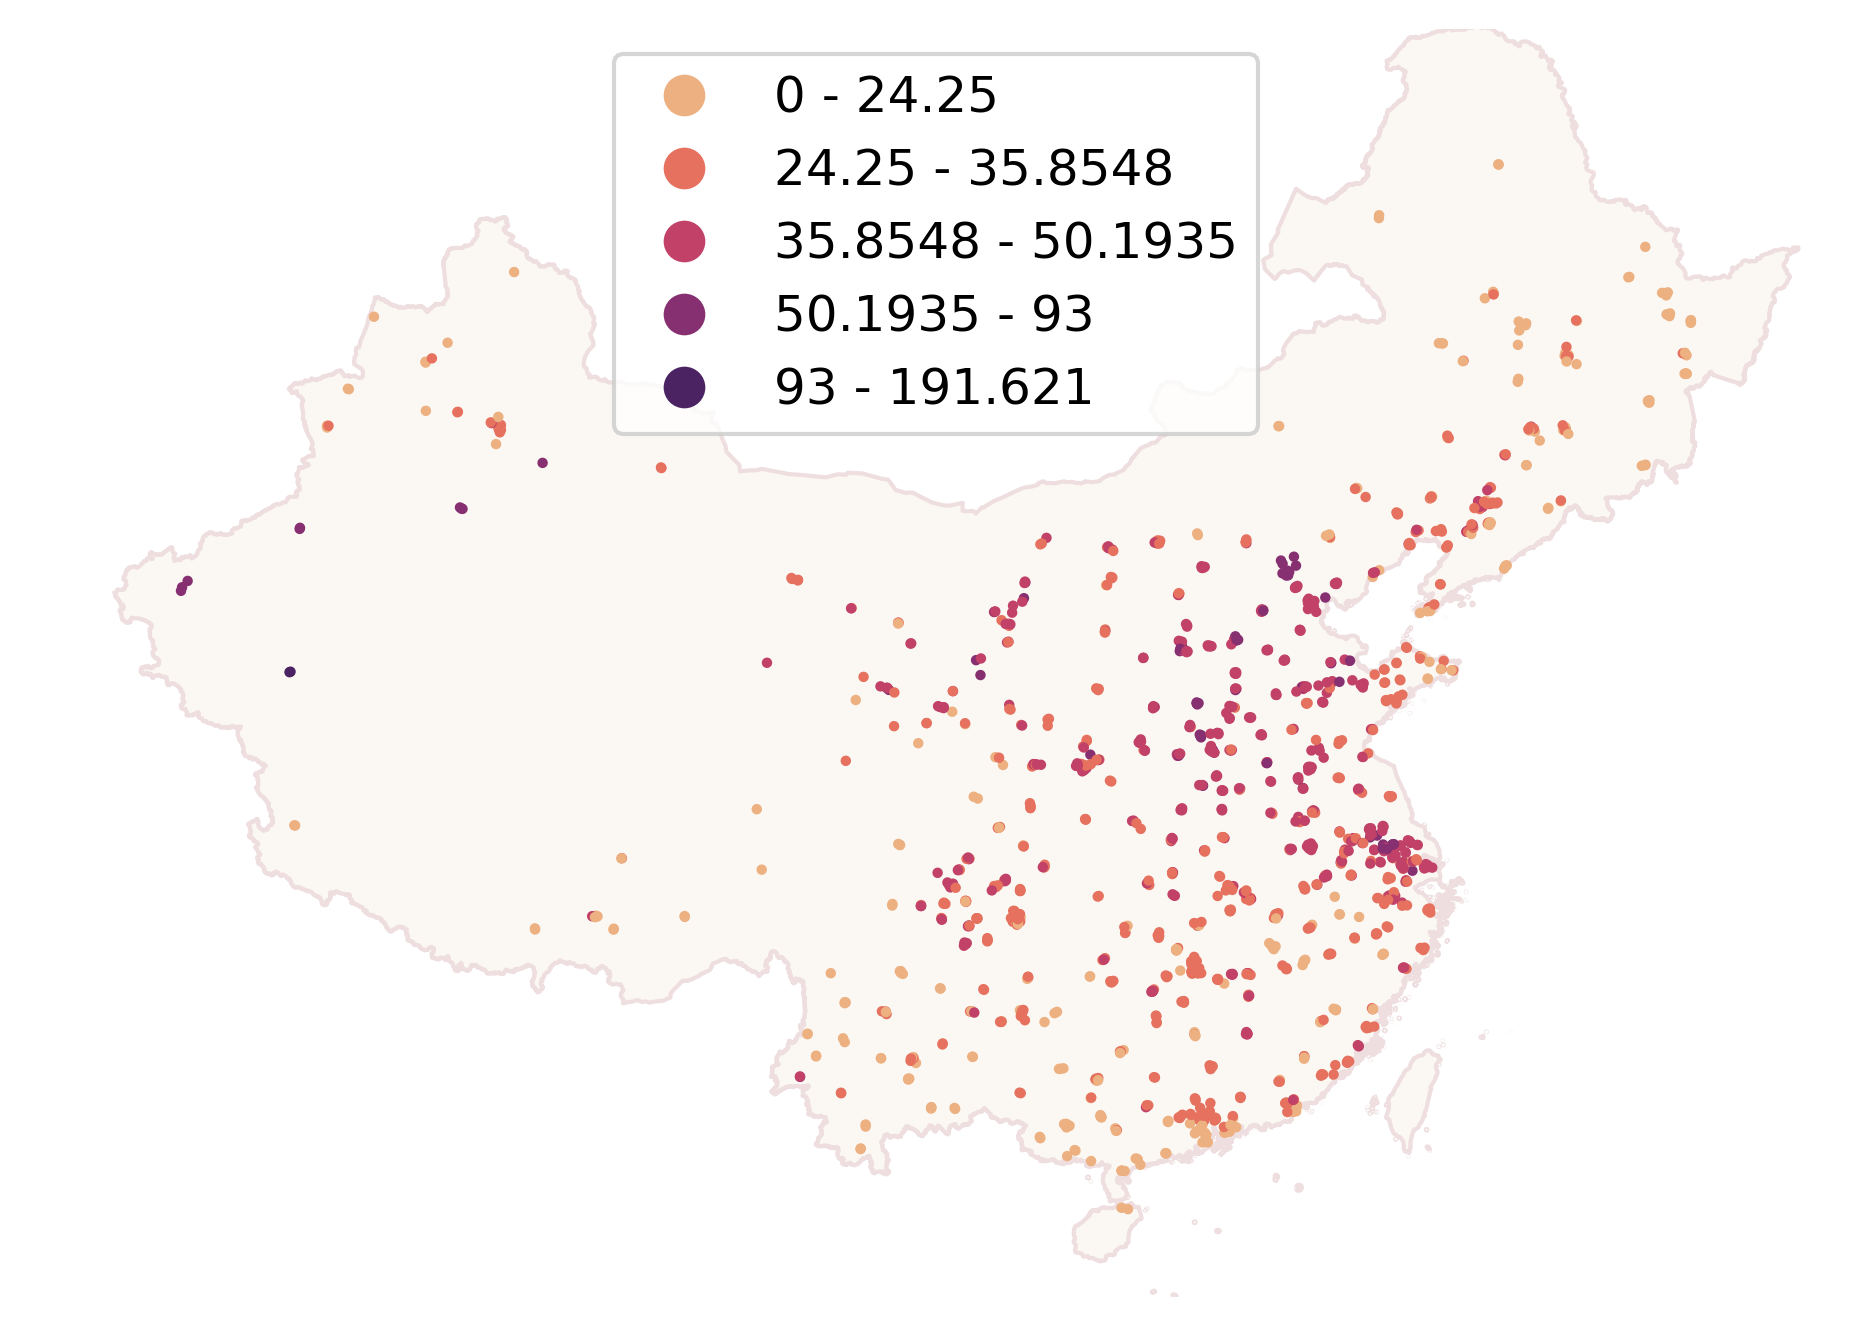

In [26]:
utm = gcrs.WebMercator()

fig, ax = plt.subplots(dpi=300, subplot_kw={'projection': utm})

gplt.polyplot(china_border, zorder=-1,
    linewidth=1,
    projection=utm,
    edgecolor='#eededf',
    facecolor='#fbf8f3', ax=ax)
gplt.pointplot(data_geo, hue='PM2.5', cmap='flare', legend=True, s=1.5, ax=ax, scheme='NaturalBreaks')

plt.tight_layout()
plt.savefig('./china_pm25_distribution_natural_breaks.pdf')
plt.show()